In [1]:
import os, glob
import sys
import pydicom
import random
import re
import scipy
import scipy.misc
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow import keras
plt.set_cmap('gray')
%matplotlib inline
## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed


IMG_DTYPE = np.float
SEG_DTYPE = np.uint8


/usr/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def read_dicom_series(directory, filepattern = "image_*"):
    """ Reads a DICOM Series files in the given directory. 
    Only filesnames matching filepattern will be considered"""
    
    if not os.path.exists(directory) or not os.path.isdir(directory):
        raise ValueError("Given directory does not exist or is a file : "+str(directory))
    print ('\tRead Dicom',directory)
    lstFilesDCM = natsort.natsorted(glob.glob(os.path.join(directory, filepattern)))
    print ('\tLength dicom series',len(lstFilesDCM))
    # Get ref file
    RefDs = dicom.read_file(lstFilesDCM[0])
    # Load dimensions based on the number of rows, columns, and slices (along the Z axis)
    ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(lstFilesDCM))
    # The array is sized based on 'ConstPixelDims'
    ArrayDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)

    # loop through all the DICOM files
    for filenameDCM in lstFilesDCM:
        # read the file
        ds = dicom.read_file(filenameDCM)
        # store the raw image data
        ArrayDicom[:, :, lstFilesDCM.index(filenameDCM)] = ds.pixel_array

    return ArrayDicom

def read_liver_lesion_masks(masks_dirname):
    """Since 3DIRCAD provides an individual mask for each tissue type (in DICOM series format),
    we merge multiple tissue types into one Tumor mask, and merge this mask with the liver mask
    
    Args:
        masks_dirname : MASKS_DICOM directory containing multiple DICOM series directories, 
                        one for each labelled mask
    Returns:
        numpy array with 0's for background pixels, 1's for liver pixels and 2's for tumor pixels
    """
    tumor_volume = None
    liver_volume = None
    
    # For each relevant organ in the current volume
    for organ in os.listdir(masks_dirname):
        organ_path = os.path.join(masks_dirname,organ)
        if not os.path.isdir(organ_path):
            continue
        
        organ = organ.lower()
        
        if organ.startswith("livertumor") or re.match("liver.yst.*", organ) or organ.startswith("stone") or organ.startswith("metastasecto") :
            print('Organ',masks_dirname,organ)
            current_tumor = read_dicom_series(organ_path)
            current_tumor = np.clip(current_tumor,0,1)
            # Merge different tumor masks into a single mask volume
            tumor_volume = current_tumor if tumor_volume is None else np.logical_or(tumor_volume,current_tumor)
        elif organ == 'liver':
            print('Organ',masks_dirname,organ)
            liver_volume = read_dicom_series(organ_path)
            liver_volume = np.clip(liver_volume, 0, 1)
    
    # Merge liver and tumor into 1 volume with background=0, liver=1, tumor=2
    label_volume = np.zeros(liver_volume.shape)
    label_volume[liver_volume==1]=1
    label_volume[tumor_volume==1]=2
    return label_volume    
            
def stat(array):
    print('min',np.min(array),'max',np.max(array),'median',np.median(array),'avg',np.mean(array))
def imshow(*args,**kwargs):
    """ Handy function to show multiple plots in on row, possibly with different cmaps and titles
    Usage: 
    imshow(img1, title="myPlot")
    imshow(img1,img2, title=['title1','title2'])
    imshow(img1,img2, cmap='hot')
    imshow(img1,img2,cmap=['gray','Blues']) """
    cmap = kwargs.get('cmap', 'gray')
    title= kwargs.get('title','')
    if len(args)==0:
        raise ValueError("No images given to imshow")
    elif len(args)==1:
        plt.title(title)
        plt.imshow(args[0], interpolation='none')
    else:
        n=len(args)
        if type(cmap)==str:
            cmap = [cmap]*n
        if type(title)==str:
            title= [title]*n
        plt.figure(figsize=(n*5,10))
        for i in range(n):
            plt.subplot(1,n,i+1)
            plt.title(title[i])
            plt.imshow(args[i], cmap[i])
    plt.show()
    
def to_scale(img, shape=None):

    height, width = shape
    if img.dtype == SEG_DTYPE:
        return scipy.misc.imresize(img,(height,width),interp="nearest").astype(SEG_DTYPE)
    elif img.dtype == IMG_DTYPE:
        max_ = np.max(img)
        factor = 255.0/max_ if max_ != 0 else 1
#         return (scipy.misc.imresize(img,(height,width),interp="nearest")/factor).astype(IMG_DTYPE)
        return np.array(Image.fromarray(img).resize([height, width])/factor).astype(IMG_DTYPE)
    else:
        raise TypeError('Error. To scale the image array, its type must be np.uint8 or np.float64. (' + str(img.dtype) + ')')


def normalize_image(img):
    """ Normalize image values to [0,1] """
    min_, max_ = float(np.min(img)), float(np.max(img))
    return (img - min_) / (max_ - min_)

In [3]:
def step1_preprocess_img_slice(img_slc):
    """
    Preprocesses the image 3d volumes by performing the following :
    1- Set pixels with hounsfield value great than 1200, to zero.
    2- Clip all hounsfield values to the range [-100, 400]
    3- Apply Adaptive Histogram Equalization
    """    
    img_slc[img_slc>1200] = 0
    img_slc   = np.clip(img_slc, -100, 400)
    img_slc = normalize_image(img_slc)

    
    img_slc = img_slc * 255
    img_slc = img_slc.astype('uint8')
#     clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
#     img_slc = clahe.apply(img_slc)
    img_slc = cv2.equalizeHist(img_slc)
    img_slc = normalize_image(img_slc)
    return img_slc

In [4]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self, id_name):
        ## Path
#         print(self.path, id_name)
#         path = os.path.normpath(self.path)
#         x = path.split(os.sep)
        patient_id = id_name.split('_')
        image_path = os.path.join(self.path,"patients", id_name)
        mask_path = os.path.join(self.path,"masks")
        all_masks = os.listdir(mask_path)
        dicom_image = pydicom.dcmread(image_path)
        image = step1_preprocess_img_slice(dicom_image.pixel_array)
        image = normalize_image(image)
        image = np.array(Image.fromarray(image).resize([image_size, image_size])).astype(IMG_DTYPE)
        
        mask = pydicom.dcmread(os.path.join(mask_path,patient_id[0]+'_liver' , id_name)).pixel_array
        mask = mask/255.0
        mask = np.clip(mask, 0, 1)
        mask = np.array(Image.fromarray(mask).resize([image_size, image_size])).astype(IMG_DTYPE)
#         mask = np.pad(liver_volume,((30,30),(30,30)),mode='reflect')
        mask = mask[:, :, np.newaxis]
        return image, mask
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
#         print(files_batch)
        image = []
        mask  = []
    
        for id_name in files_batch:
#             return len(files_batch)
            _img, _mask = self.__load__(id_name)
#             _img = _img.astype(np.uint8)
#             _img = cv2.cvtColor(_img,cv2.COLOR_GRAY2RGB)
#             _img = np.broadcast_to(_img[..., np.newaxis], (128, 128, 3))
            _img = np.stack((_img,)*3, axis=-1)
            image.append(_img)
            mask.append(_mask)
        
        image = np.array(image)
        mask  = np.array(mask)
#         image = image[:, :, np.newaxis]
#         image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB) 

        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))
    


In [5]:
image_size = 256
train_path = "train"
batch_size = 8
epochs = 20

## Training Ids
images = []
for file in os.listdir(os.path.join(train_path, "patients")):
#     if not file.endswith('_augrot') and not file.endswith('_augref'):
        images.append(file)
print(len(images))

## Validation Data Size
val_data_size = len(images)//5

valid_ids = images[:val_data_size]
train_ids = images[val_data_size:]

20275


In [6]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
# print(train_ids[2])
x, y = gen.__getitem__(0)
# for i in range(0, len(y)):
#     for j in range(0, len(y[i])):
#         for k in range(0, len(y[i][j])):
#             if(y[i][j][k][0] > 0):
#                 print(y[i][j][k][0])
# print(y)
# print(x.shape, y.shape)
# print(gen.__getitem__(0))

1


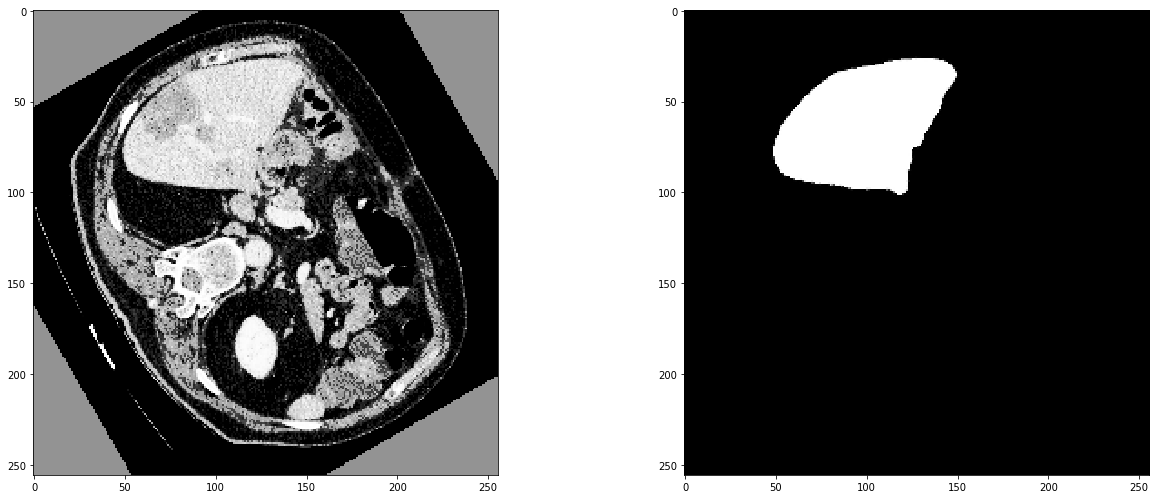

In [7]:
r = random.randint(0, len(x)-1)
fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
print(r)
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

In [8]:
def bn_act(x, act=True):
    x = keras.layers.BatchNormalization()(x)
    if act == True:
        x = keras.layers.Activation("relu")(x)
    return x

def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = bn_act(x)
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv

def stem(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    
    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = keras.layers.Add()([conv, shortcut])
    return output

def residual_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)
    
    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = keras.layers.Add()([shortcut, res])
    return output

def upsample_concat_block(x, xskip):
    u = keras.layers.UpSampling2D((2, 2))(x)
    c = keras.layers.Concatenate()([u, xskip])
    return c

In [9]:
def ResUNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    ## Encoder
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides=2)
    e3 = residual_block(e2, f[2], strides=2)
    e4 = residual_block(e3, f[3], strides=2)
    e5 = residual_block(e4, f[4], strides=2)
    
    ## Bridge
    b0 = conv_block(e5, f[4], strides=1)
    b1 = conv_block(b0, f[4], strides=1)
    
    ## Decoder
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4])
    
    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])
    
    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])
    
    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1])
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
    model = keras.models.Model(inputs, outputs)
    return model

In [10]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = tf.layers.flatten(y_true)
    y_pred_f = tf.layers.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [11]:
model = ResUNet()
adam = keras.optimizers.Adam()
model.compile(optimizer=adam, loss=dice_coef_loss, metrics=["acc", dice_coef])
model.summary()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 16) 0           batch_normalization_1[0][0]      
____________________________________

In [12]:
# os.environ ['CUDA_VISIBLE_DEVICES'] = '1' 
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size
# with tf.device('/gpu:0'):
model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
                    epochs=epochs)

Epoch 1/20
2027/2027 [==============================]2027/2027 [==============================] - 996s 491ms/step - loss: 0.1306 - acc: 0.9736 - dice_coef: 0.8694 - val_loss: 0.1069 - val_acc: 0.9758 - val_dice_coef: 0.8931

Epoch 2/20
2027/2027 [==============================]2027/2027 [==============================] - 736s 363ms/step - loss: 0.0991 - acc: 0.9791 - dice_coef: 0.9009 - val_loss: 0.1570 - val_acc: 0.9700 - val_dice_coef: 0.8430

Epoch 3/20
2027/2027 [==============================]2027/2027 [==============================] - 734s 362ms/step - loss: 0.0980 - acc: 0.9791 - dice_coef: 0.9020 - val_loss: 0.0977 - val_acc: 0.9784 - val_dice_coef: 0.9023

Epoch 4/20
2027/2027 [==============================]2027/2027 [==============================] - 734s 362ms/step - loss: 0.0768 - acc: 0.9822 - dice_coef: 0.9232 - val_loss: 0.0947 - val_acc: 0.9783 - val_dice_coef: 0.9053

Epoch 5/20
2027/2027 [==============================]2027/2027 [==============================] - 73

In [14]:
model.save('liver_model_final_resunet.h5')  # creates a HDF5 file 'my_model.h5'
model.save_weights("liver_model_weights_final_resunet.h5")

In [12]:
# del model
# model.save('liver_CNN.h5')  # creates a HDF5 file 'my_model.h5'

# model = keras.models.load_model('liver_CNN.h5', compile= False)
# model.summary()
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

(8, 128, 128, 3) (8, 128, 128, 1)


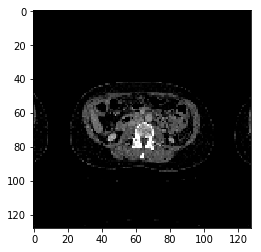

In [35]:
x, y = valid_gen.__getitem__(7)
result = model.predict(x)

result = result > 0.5
print(x.shape, result.shape)

imshow(x[1])

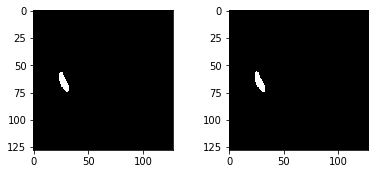

In [36]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[1]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[1]*255, (image_size, image_size)), cmap="gray")

/usr/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


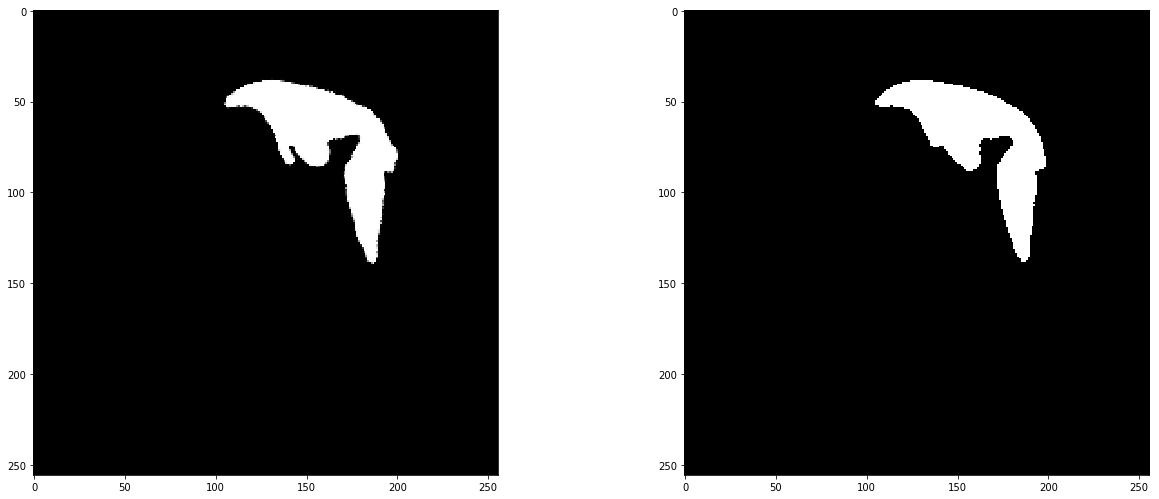

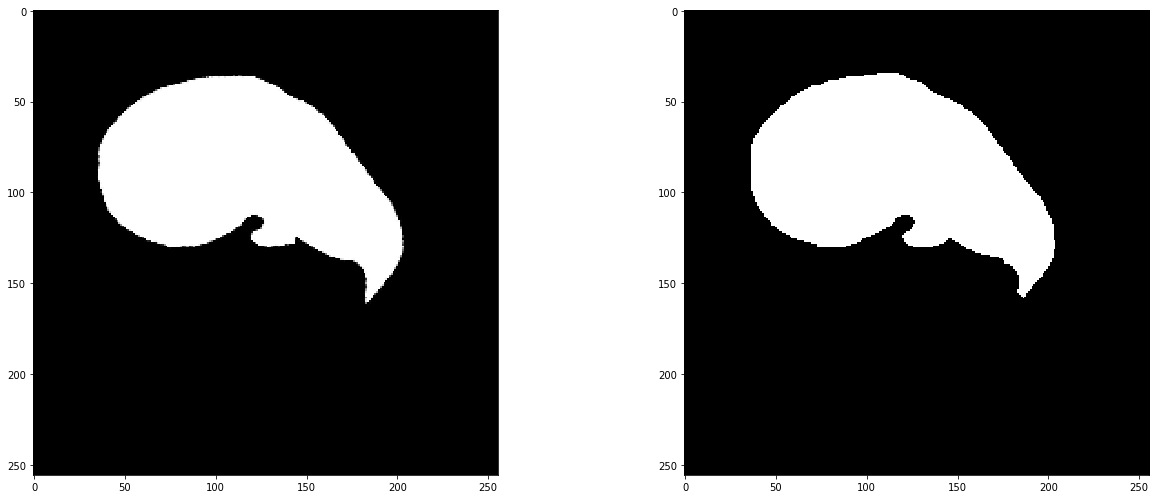

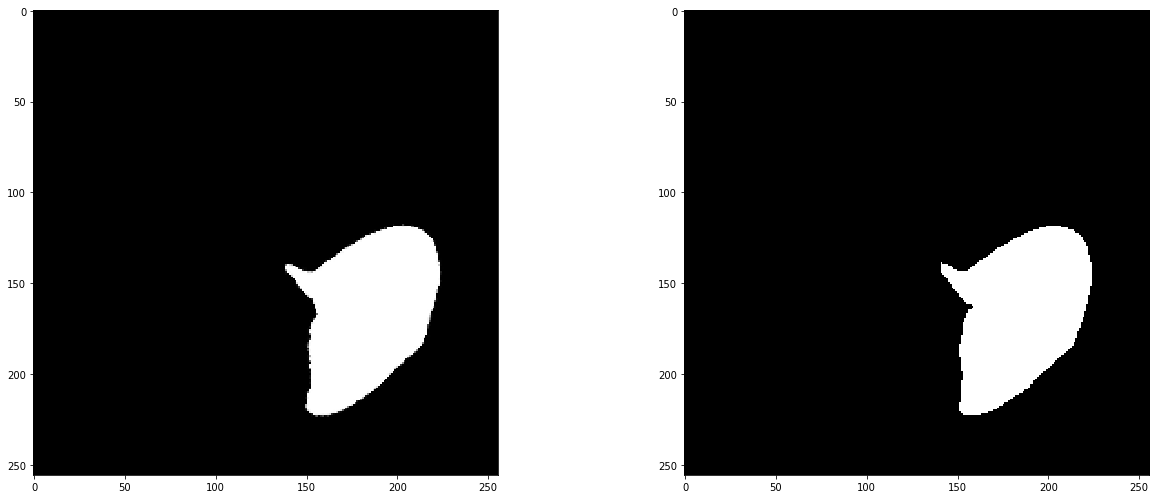

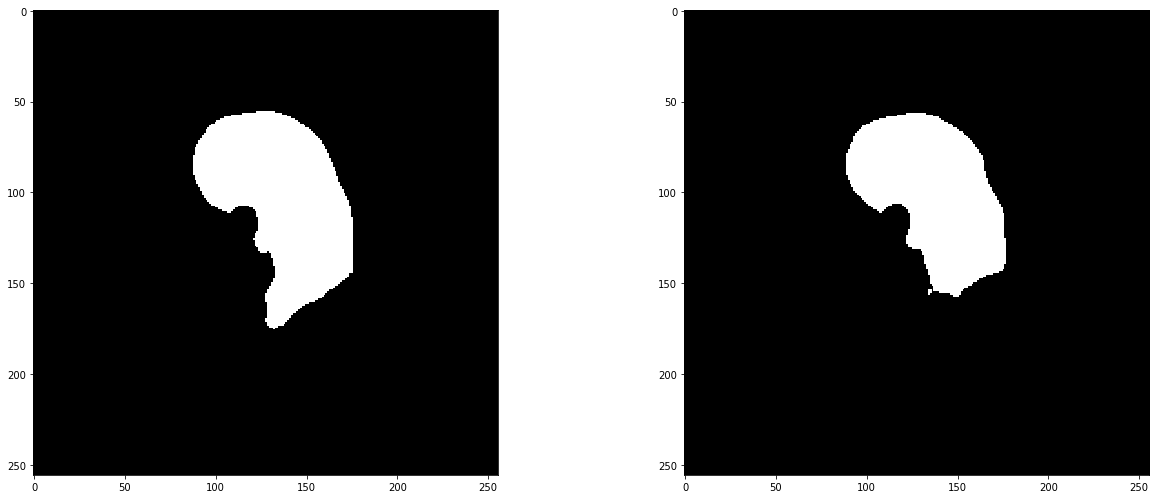

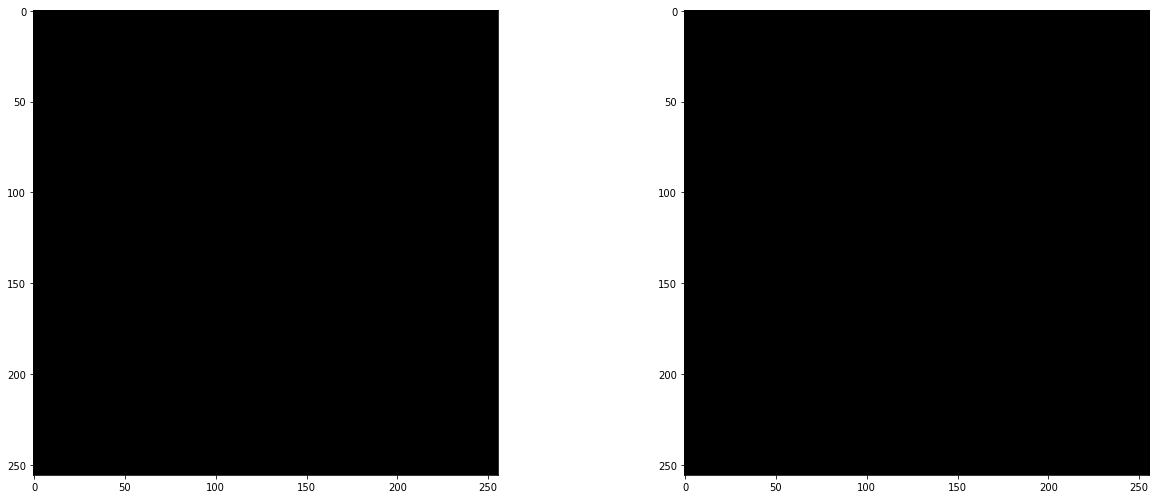

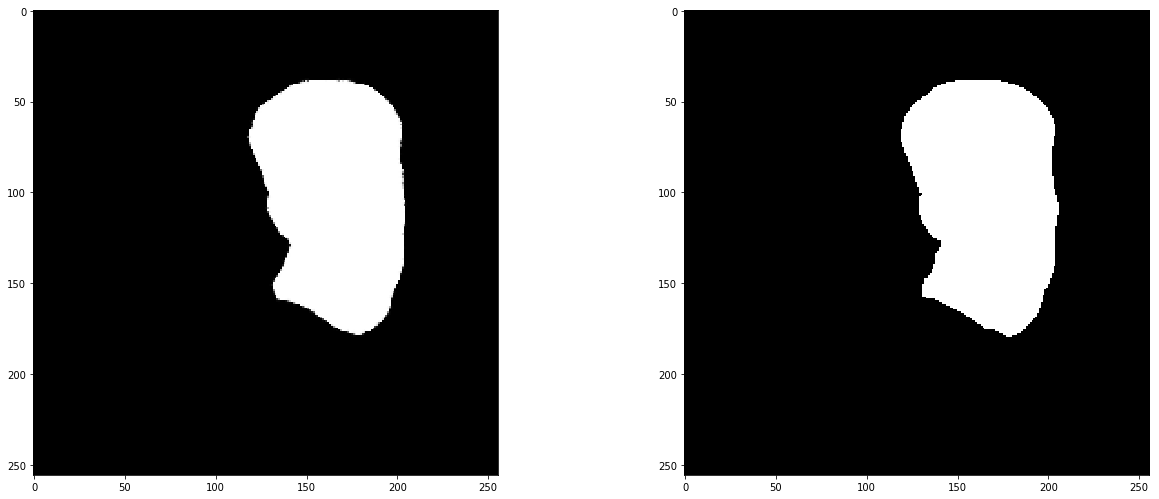

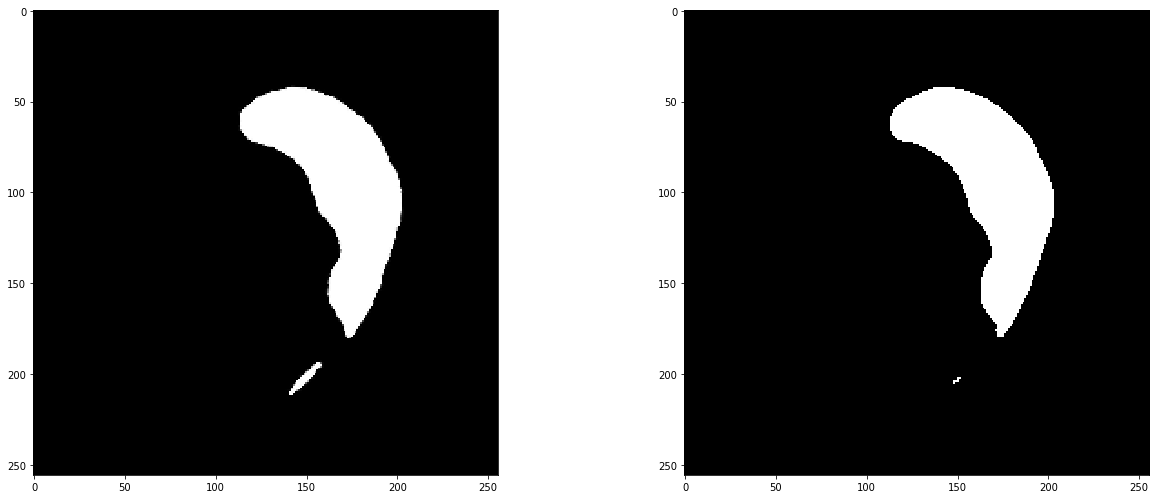

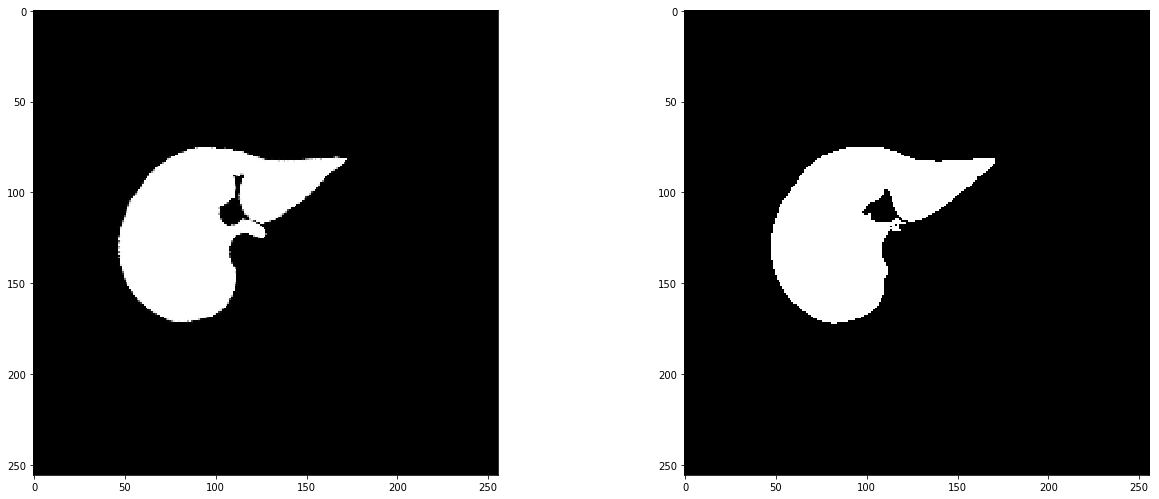

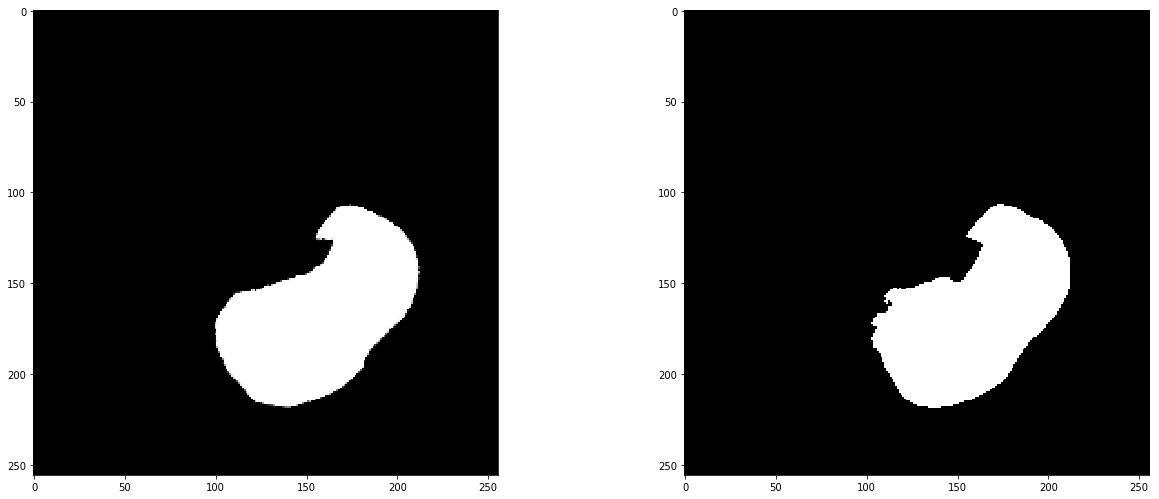

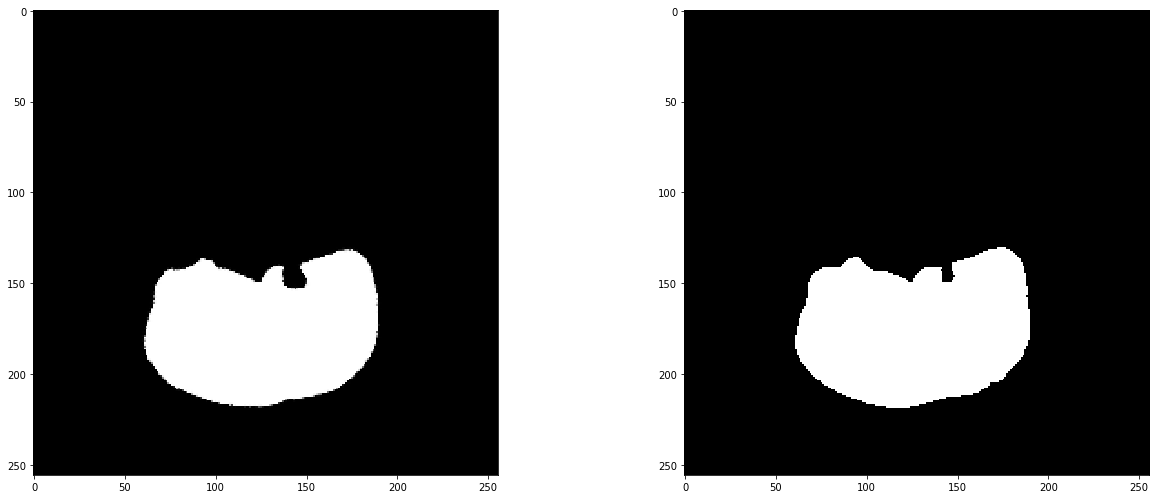

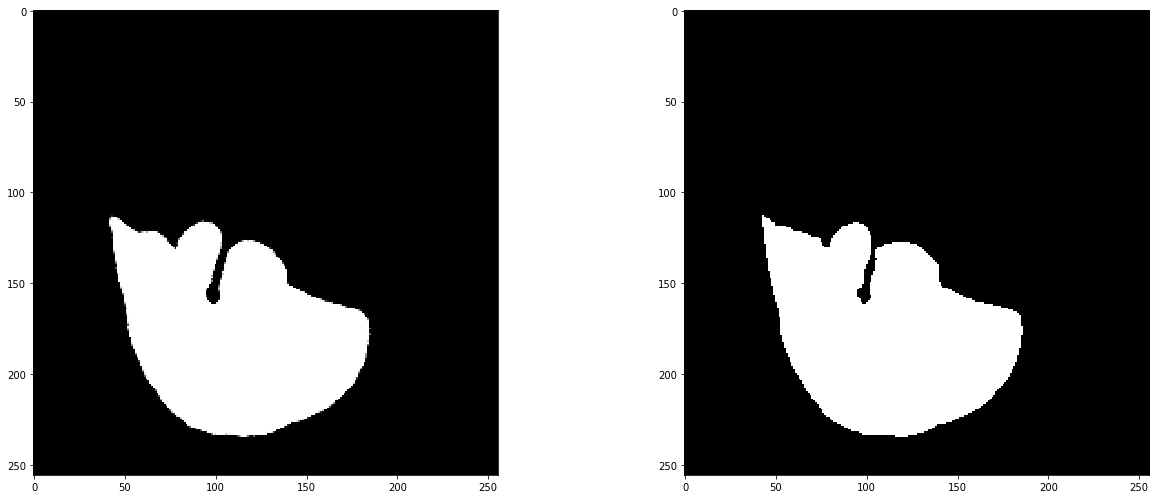

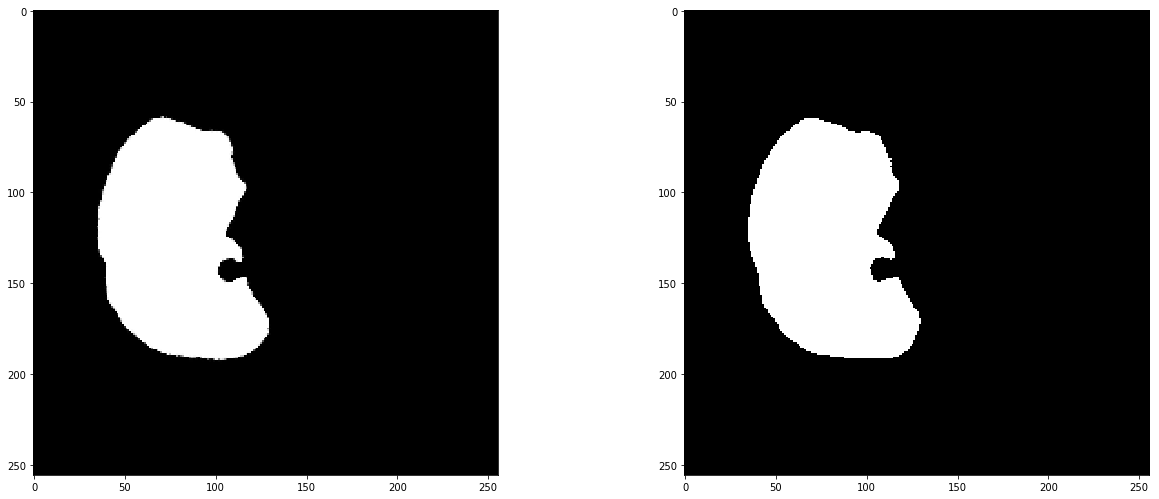

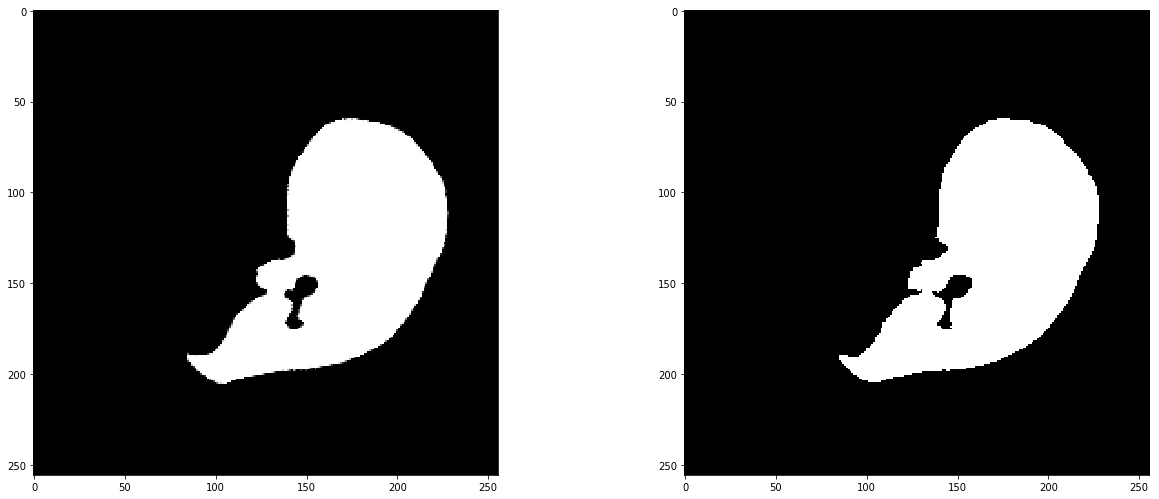

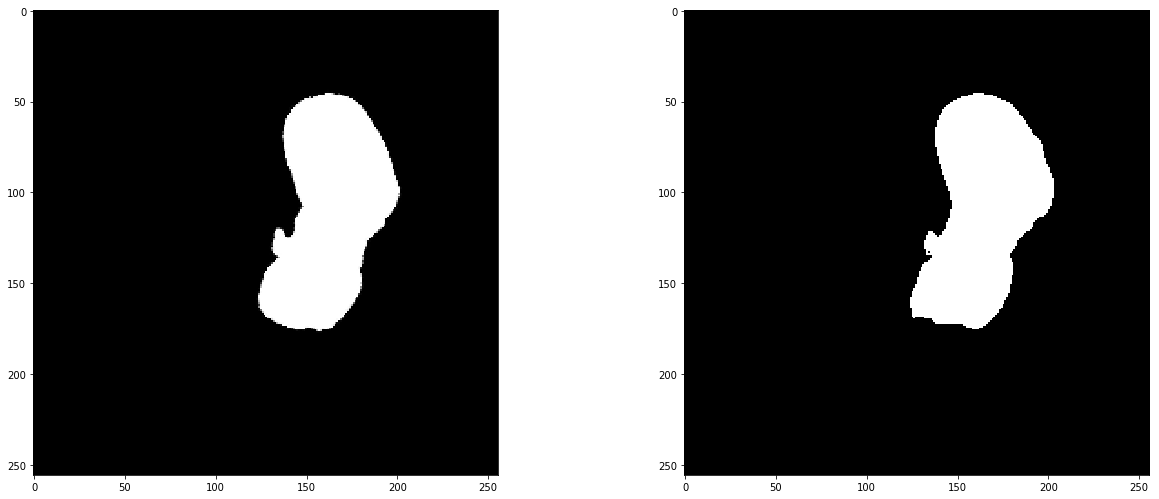

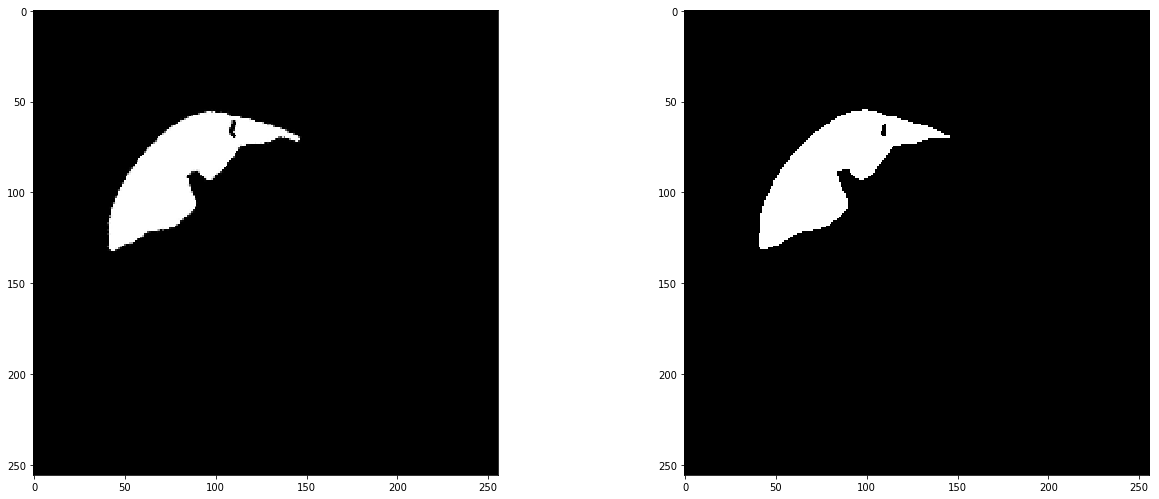

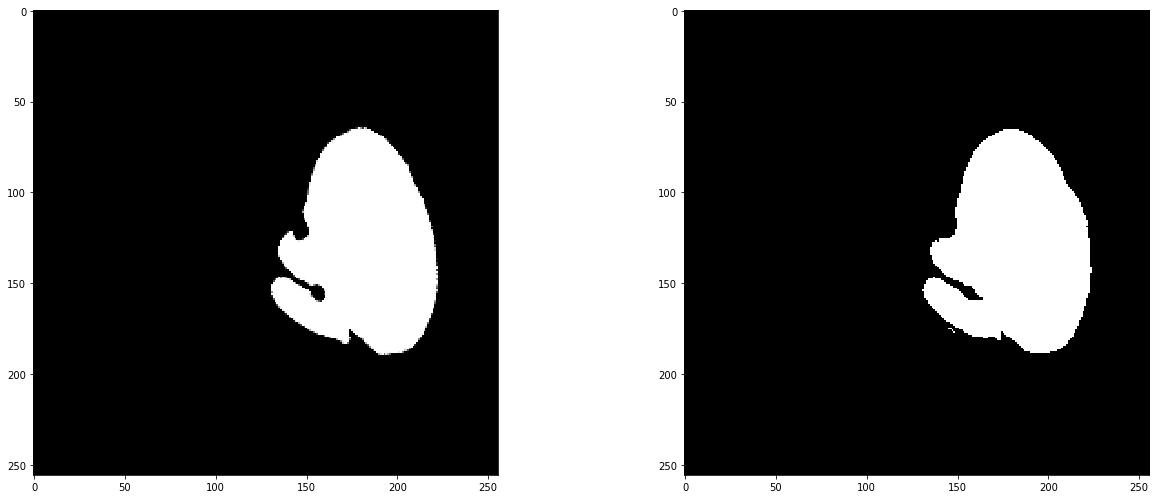

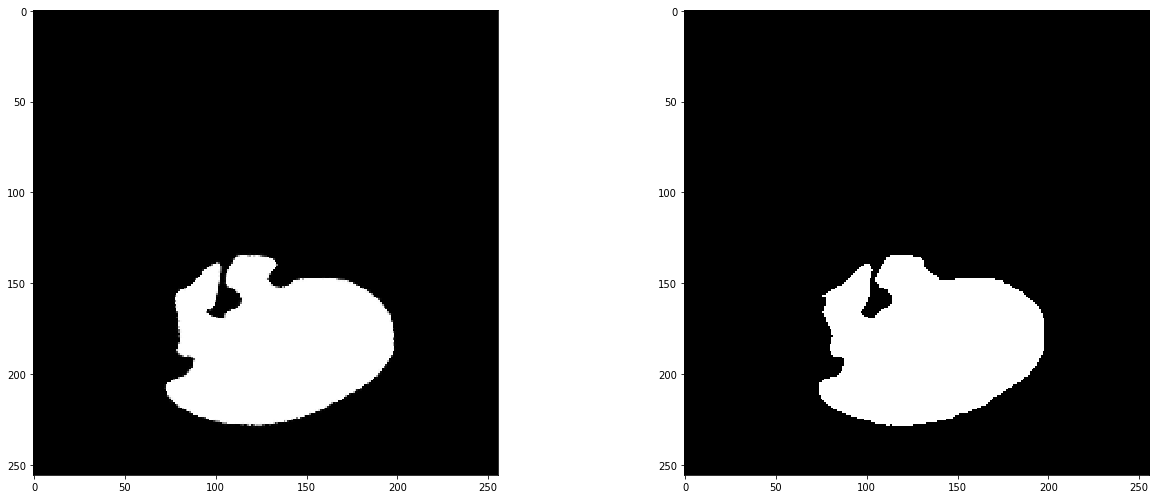

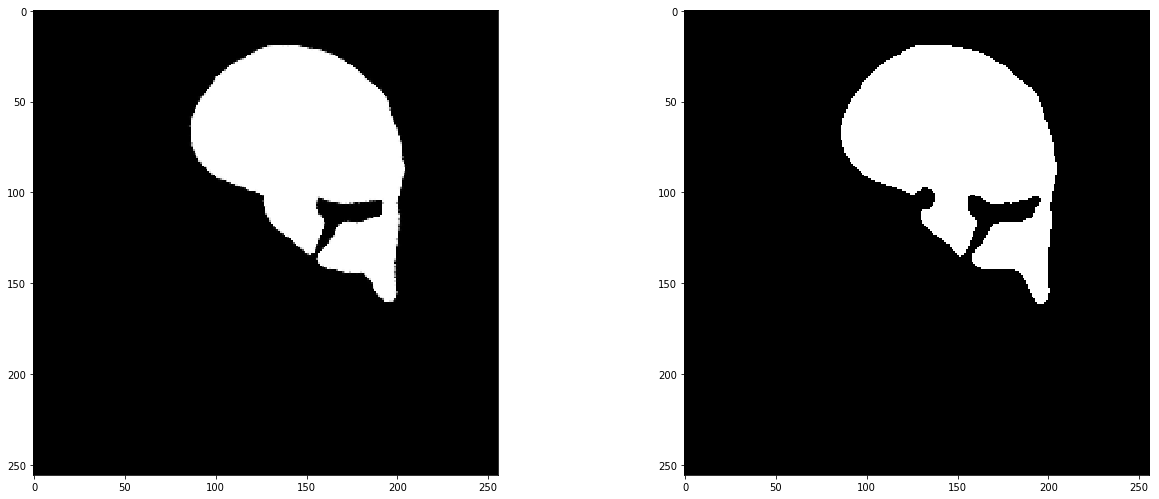

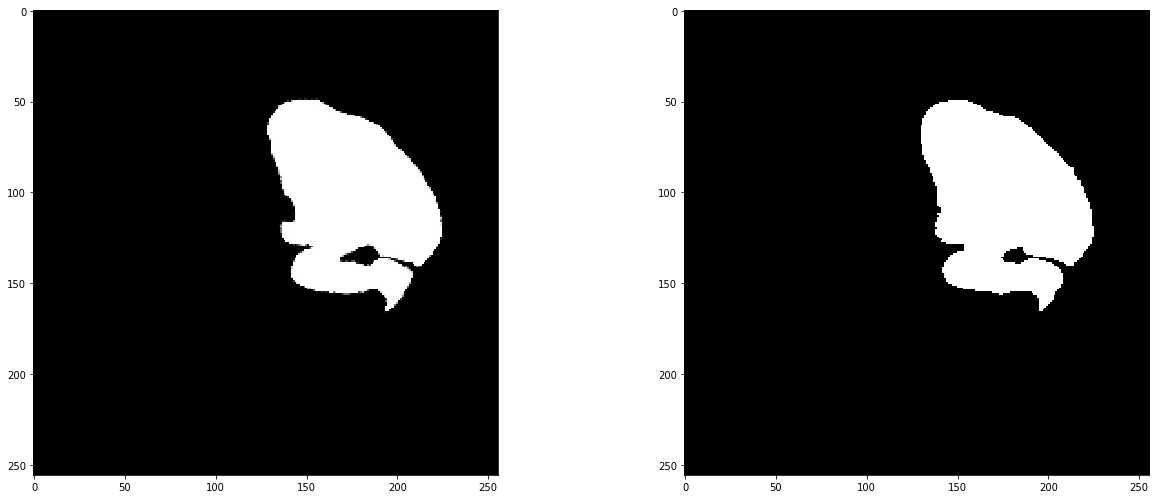

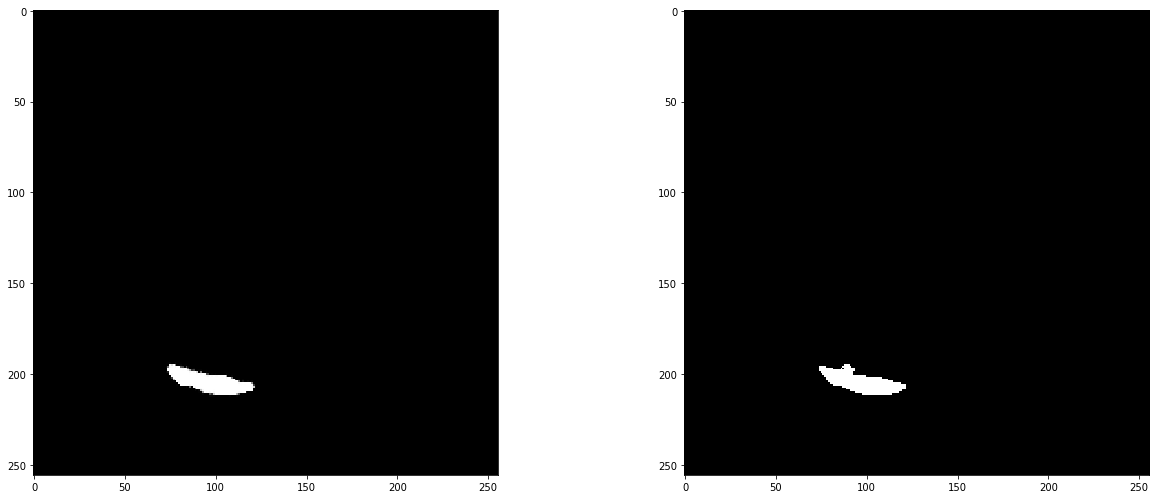

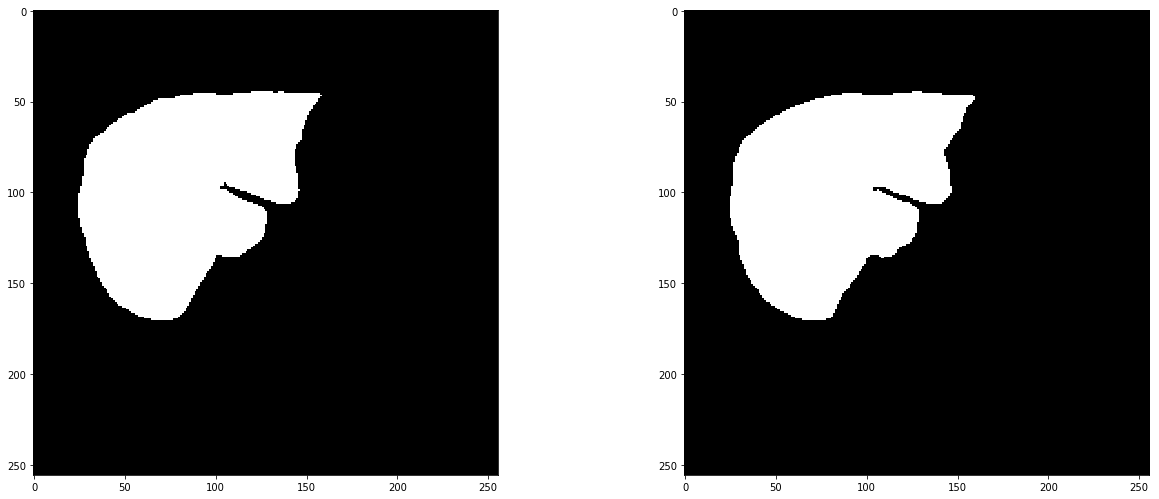

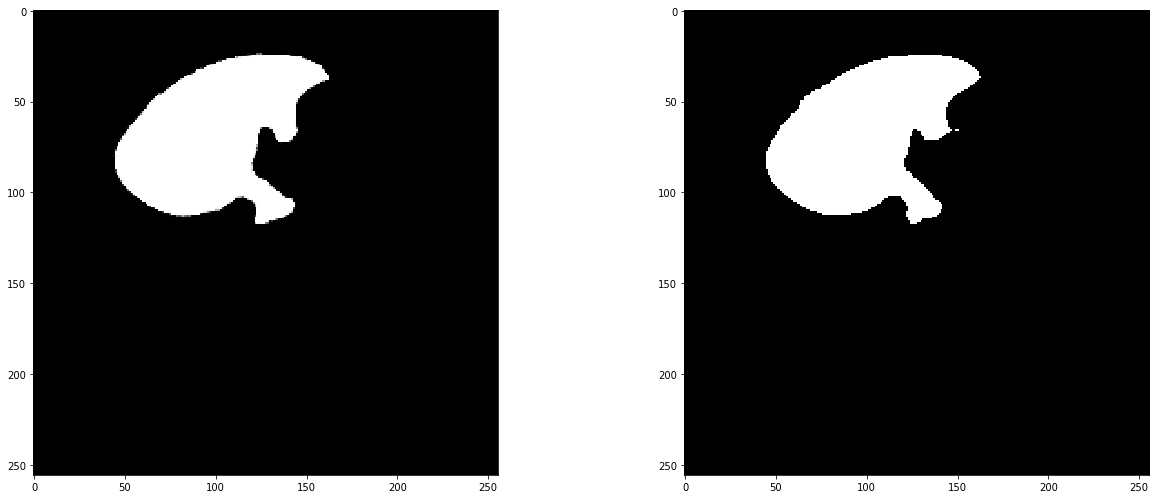

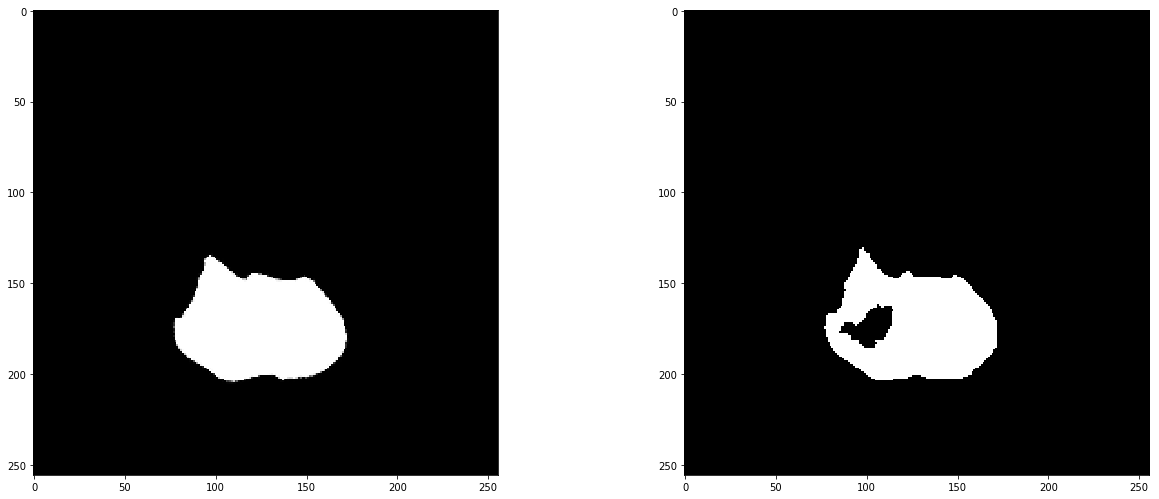

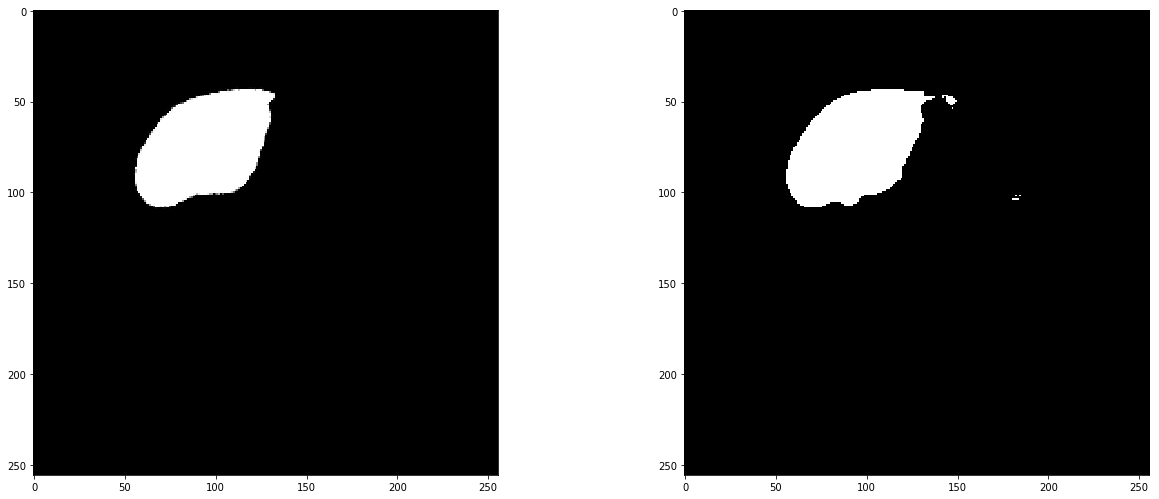

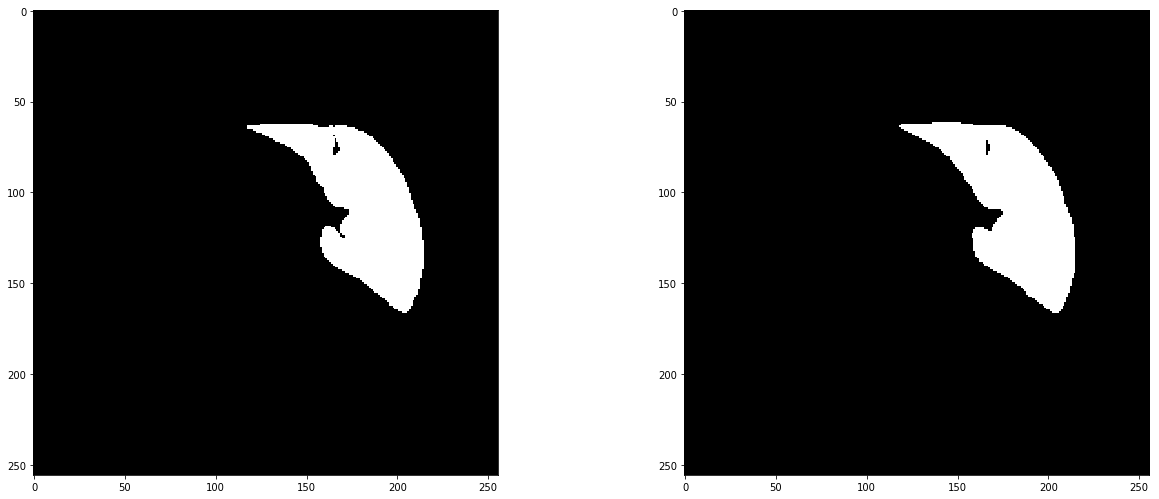

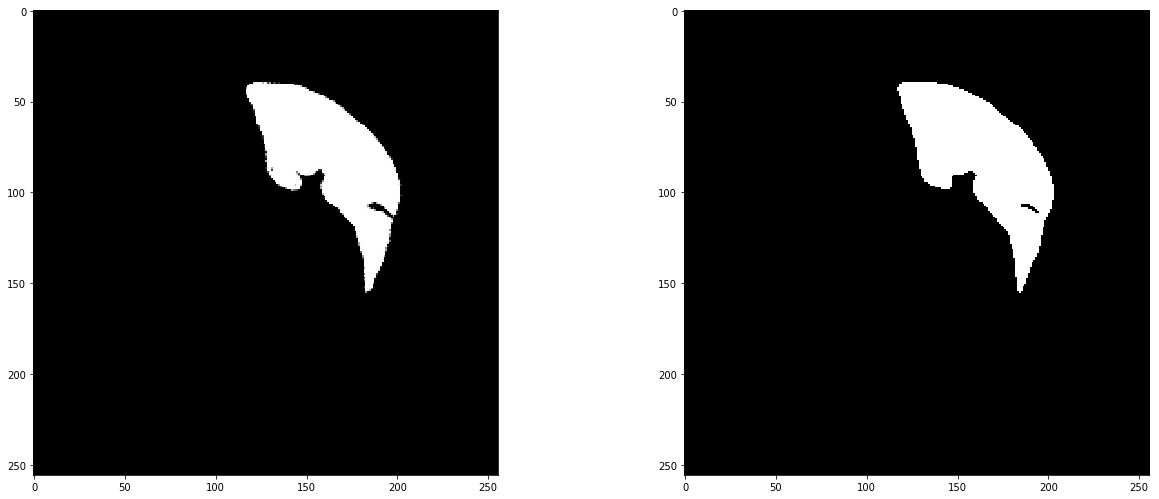

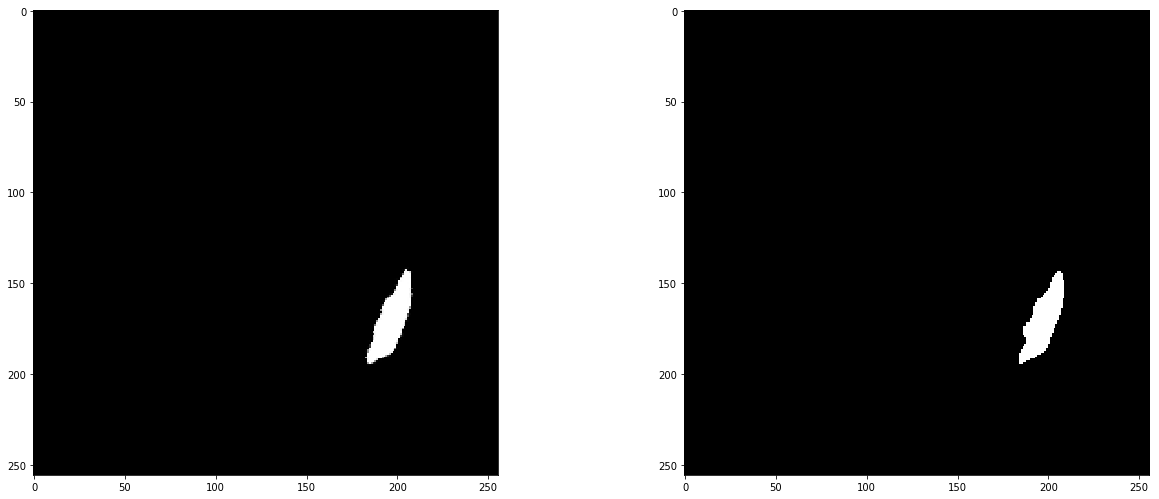

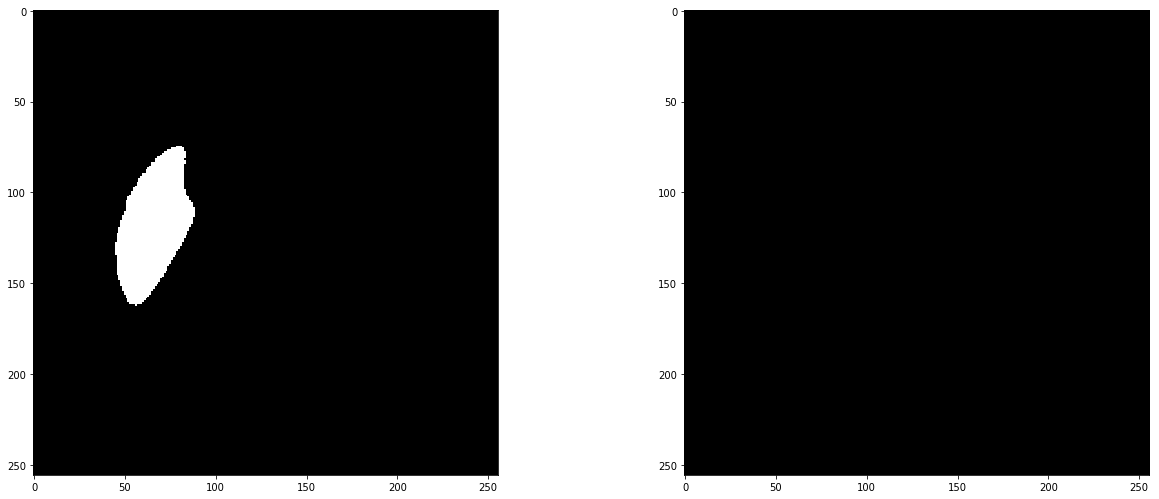

In [13]:
for i in range(1, 5, 1):
    ## Dataset for prediction
    x, y = valid_gen.__getitem__(i)
    result = model.predict(x)
    result = result > 0.4
    
    for i in range(len(result)):
        fig = plt.figure(figsize=(20,20))
        fig.subplots_adjust(hspace=0.4, wspace=0.4)

        ax = fig.add_subplot(1, 2, 1)
        ax.imshow(np.reshape(y[i]*255, (image_size, image_size)), cmap="gray")
#         ax.imshow(x[i])
        ax = fig.add_subplot(1, 2, 2)
        ax.imshow(np.reshape(result[i]*255, (image_size, image_size)), cmap="gray")